In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [ ]:
# average score, module attributions (training celltypes only)
src_train = df.loc[df.Training == True].index
msk = adata.obs.source.isin(src_train) & (adata.obs.trajectory == 'True')
grp = adata[msk].obs.groupby(['source', 'celltype'], observed = True)
z = grp.latent_z.mean().sort_values(ascending = False).loc[grp.size() > 200]
attr = grp[src_train].mean().loc[z.index]

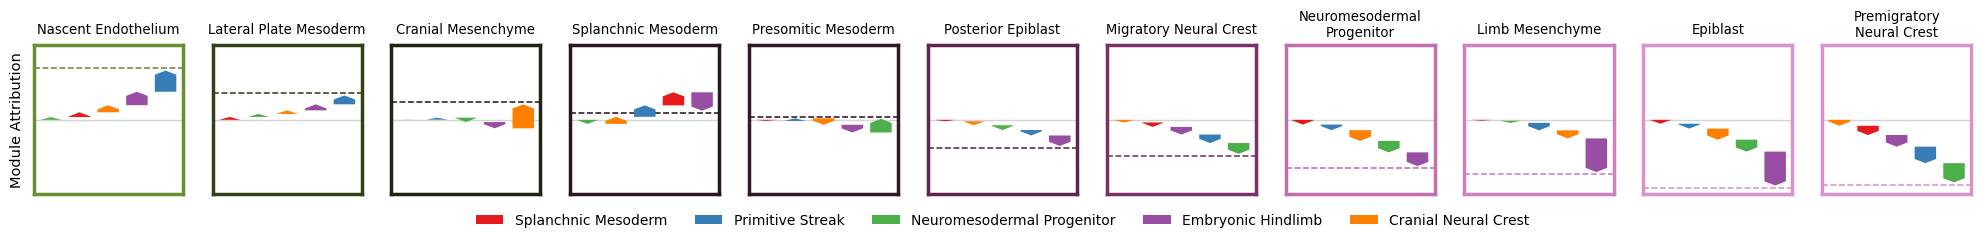

In [25]:
# waterfall plots
wbar, hlen, pad, cmap = .75, .035, [.6, .075], plt.cm.Set1
colors = {col : cmap(i) for i, col in enumerate(attr.columns)}
xlim = (-pad[0], attr.shape[1] - 1 + pad[0])
ylim = attr.sum(axis = 1).abs().max() + pad[1]

# plot grid
fs1, fs2, cmap_z = 9.5, 10.5, plt.cm.vanimo
fig, ax = plt.subplots(1, attr.shape[0], figsize = (25, 5))
for i, ix in enumerate(attr.index):
    attr_i = attr.loc[ix].sort_values(key = abs)
    heads = attr_i.cumsum().to_numpy()
    tails = np.concat(([0], heads[:-1]))
    colors_i = attr_i.index.map(colors)
    color_zi = cmap_z(z.loc[ix])
  
    # plot bars
    for j in range(heads.size):
        dy = heads[j] - tails[j]
        head_length = min(abs(dy), hlen)
        arrow = FancyArrow(
            x = j,
            y = tails[j],
            dx = 0,
            dy = dy,
            width = wbar,
            head_width = wbar,
            head_length = head_length,
            length_includes_head = True,
            linewidth = 0,
            color = colors_i[j])
        ax[i].add_artist(arrow)

    # zero attribution
    ax[i].axhline(0,
                  color = 'lightgray',
                  linewidth = 1,
                  zorder = 0)
    
    # total attribution
    ax[i].axhline(heads[j] + .0185 * np.sign(dy),
                  color = color_zi,
                  linestyle = '--',
                  linewidth = 1.15,
                  zorder = 0)
    
    # average score
    for sp in ax[i].spines.values():
        sp.set_color(color_zi)
        sp.set_linewidth(2.5)

    ax[i].set_title(ix[1], size = fs1, pad = 8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(-ylim, ylim)
    ax[i].set_box_aspect(1)

for i in (7, 10):
    title = ax[i].get_title().replace(' ', '\n', 1)
    ax[i].set_title(title, size = fs1)

ax[0].set_ylabel('Module Attribution',
                 size = fs2, labelpad = 7)

# legend
handles = [Patch(facecolor = val, label = df.loc[key].Name)
           for key, val in colors.items()]
ax[5].legend(handles = handles,
             loc = 'center',
             fontsize = fs1 + .5,
             frameon = False,
             ncol = len(handles),
             bbox_to_anchor = (.5, -.175))

fn = os.path.join(pth_out, 'attributions.pdf')
plt.savefig(fn, bbox_inches = 'tight')